In [2]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)



In [17]:
data_test[data_test.longitude > 45][['latitude','longitude']]

,latitude,longitude
2529,42.914700,74.517184
4719,43.353545,132.768097
9547,43.352968,132.759204


<AxesSubplot:xlabel='phones', ylabel='price'>

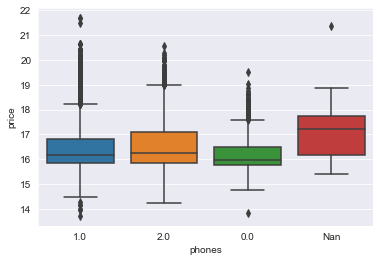

In [48]:
nan_idx = data['phones'].isna()
data.loc[nan_idx, 'phones'] = "Nan"
sns.boxplot(y = np.log(data['price']), x = data['phones'])

<AxesSubplot:xlabel='condition', ylabel='price'>

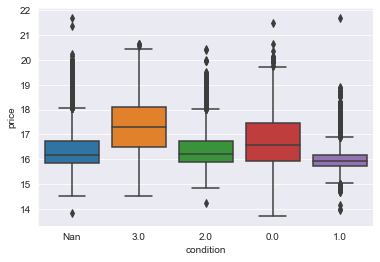

In [5]:
nan_idx = data['condition'].isna()
data.loc[nan_idx, 'condition'] = "Nan"
sns.boxplot(y = np.log(data['price']), x = data['condition'])

# Exploring 'address'
There does not seem to be a significant difference between the groups I have divided address into.

In [56]:
a = data['address']
for i in range(len(a)):
    if a[i].isdecimal():
        a[i] = 1
    elif 'к' in a[i]:
        a[i] = 2
    elif 'К' in a[i]:
        a[i] = 3
    else:
        a[i] = 0

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD f

<AxesSubplot:xlabel='address', ylabel='price'>

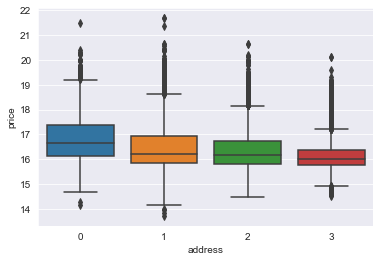

In [43]:
sns.boxplot(y = np.log(data['price']), x = a)

# Exploring 'district'

<AxesSubplot:xlabel='district', ylabel='price'>

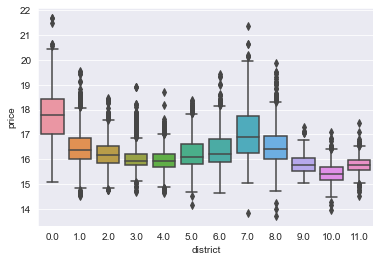

In [44]:
sns.boxplot(y = np.log(data['price']), x = data['district'])

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


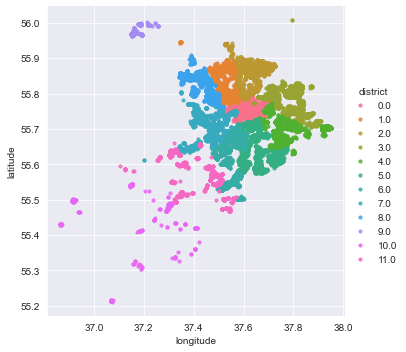

In [57]:
sns.lmplot('longitude', 'latitude', data=data, hue='district', fit_reg=False, scatter_kws={"s": 10})

# Numerical Features
First, I look at the numerical features, before I treat the categorical ones. I do both a pairs plot to look for any interesting patterns, and calculate the covaraiance of each numerical feeature with the response.

In [50]:
df = data[ [column for column in data if column not in ['id']]]
df_num = df.select_dtypes(include = ['float64', 'int64'])
print("Features that are not numerical:")
for c in df.columns:
    if c not in df_num.columns:
        print(c)
df_num["price"] = np.log(df_num["price"])
df_num.head()
df_num.shape
df_num.isnull().sum()/df_num.shape[0]

Features that are not numerical:
condition
phones
street
address


/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


seller                0.379214
price                 0.000000
area_total            0.000000
area_kitchen          0.202749
area_living           0.166717
floor                 0.000000
rooms                 0.000000
layout                0.757655
ceiling               0.476401
bathrooms_shared      0.166287
bathrooms_private     0.166287
windows_court         0.346661
windows_street        0.346661
balconies             0.451793
loggias               0.451793
building_id           0.000000
new                   0.011338
latitude              0.000000
longitude             0.000000
district              0.005583
constructed           0.034099
material              0.170582
stories               0.000000
elevator_without      0.015332
elevator_passenger    0.015332
elevator_service      0.015332
parking               0.291518
garbage_chute         0.378398
heating               0.350483
dtype: float64

There are only two features which are non-numeric, and they are probably useless anyway. There are quite a lot of null-values. Might have to discard the features that have the most.

## Pairs plot

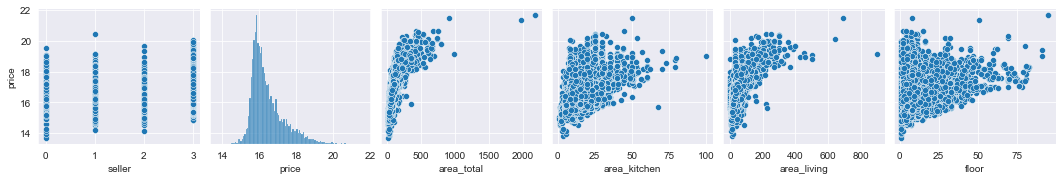

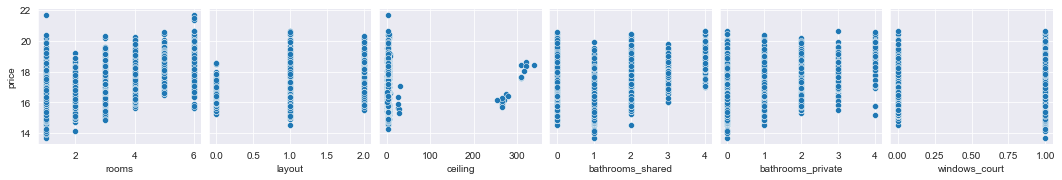

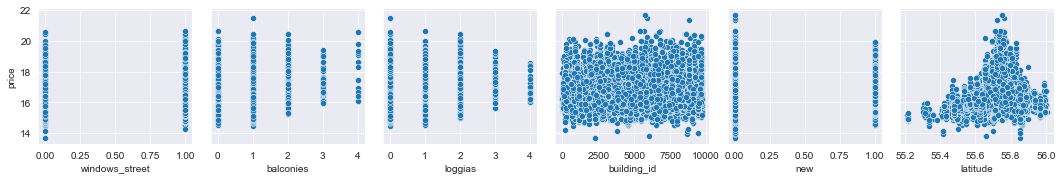

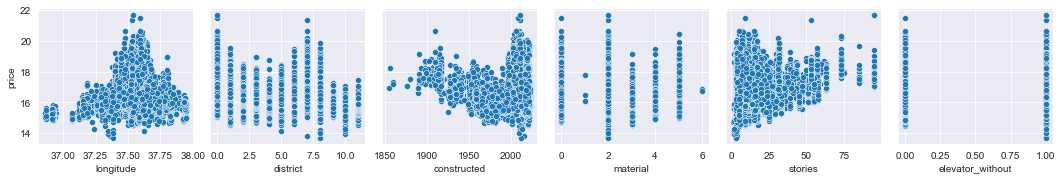

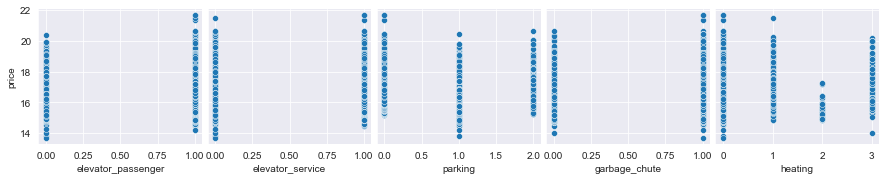

In [51]:
for i in range(0, len(df_num.columns), 6):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+6],
                y_vars=['price'])

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='price'>

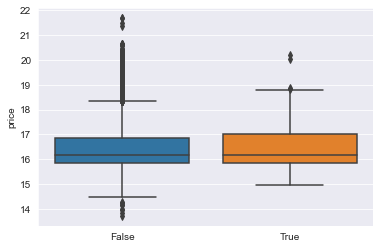

In [65]:
df_num['fds'] = df_num['floor']/df_num['stories']
#plt.scatter(df_num['fds'], np.log(df_num['price']))
high_floor = df_num['floor'] > df_num['stories']
sns.boxplot(y = df_num['price'], x = high_floor)

In [72]:
f, ax=plt.subplots(1, 1, figsize=(12, 6))
sns.violinplot("price", "floor", hue="elevator_service", data=df_num, split=True, ax=ax)
ax.set_title('Sex and Age vs Survived')
ax.set_yticks(range(0, 110, 10))
plt.show()

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


KeyboardInterrupt: 

## Correlations 
First I find the features that have a high (0.5) correlation with the response.

In [1]:
corr_list = df_num[df_num.columns[1:]].corr()['price'][:]
print(corr_list["constructed"])
high_corr = corr_list.loc[abs(corr_list)> 0.2]
high_corr
high_corr_list = high_corr.index.tolist()
high_corr_list

NameError: name 'df_num' is not defined

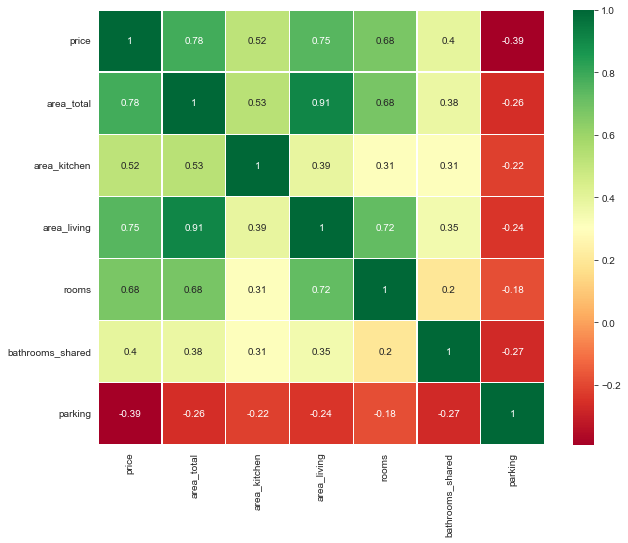

In [9]:
high_corr_df = df_num[high_corr_list]
sns.heatmap(high_corr_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

We see that there is pretty high correlations between all these features, which is not surprising. Should maybe combine them into a single feature.

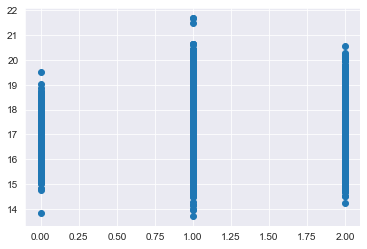

In [13]:
data_phone = data.loc[ ~data["phones"].isna()]
plt.scatter(data_phone["phones"], np.log(data_phone["price"]))


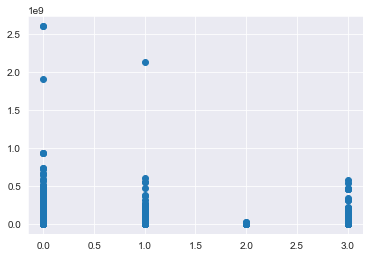

In [17]:
#plt.scatter(data["condition"], data["price"])
plt.scatter(data["heating"], data["price"])


# 'construction' feature 
There seems to be some nonlinear relationship with the response.

Imputation: Maybe use longitude and latitude to impute missung values for construction? A simple decision tree may be suited.

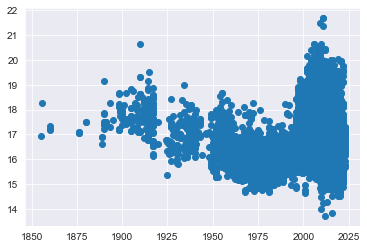

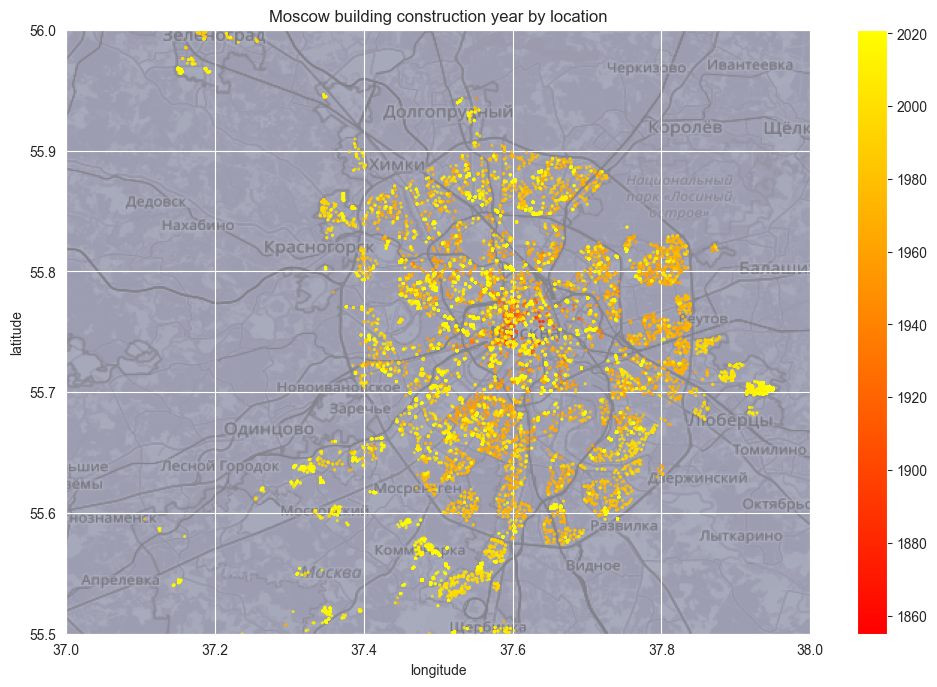

In [44]:
plt.scatter(data["constructed"], np.log(data["price"]))

def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='constructed', title='Moscow building construction year by location'):
    data = data[['latitude', 'longitude', column]].dropna().sort_values(by=column, ascending=True)
    backdrop = plt.imread('resources/data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(data);

# Houses outside Moscow

In [35]:
data_test.loc[(data_test.longitude < 35) | (data_test.latitude > 60) | (data_test.latitude < 55) | (data_test.longitude  > 38 ), ["latitude", "longitude"]]

,latitude,longitude
2511,17.141734,-61.790500
2529,42.914700,74.517184
4719,43.353545,132.768097
5090,17.141734,-61.790500
6959,17.141734,-61.790500
8596,17.141734,-61.790500
9547,43.352968,132.759204


In [39]:
pd.set_option('display.max_columns', 500)
data_test.loc[(data_test.latitude == 17.141734) & (data_test.longitude == -61.790500)]

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
2511,25796,NaN,19.8,5.1,9.4,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4636,1.0,17.141734,-61.7905,NaN,Бунинские Луга ЖК,к2/2/1,2021.0,3.0,17.0,1.0,0.0,0.0,NaN,0.0,NaN
5090,28375,0.0,43.6,5.0,28.8,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4412,1.0,17.141734,-61.7905,NaN,Бунинские Луга ЖК,к2/2/2,2021.0,NaN,9.0,0.0,1.0,1.0,NaN,NaN,NaN
6959,30244,NaN,19.8,5.1,9.4,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4636,1.0,17.141734,-61.7905,NaN,Бунинские Луга ЖК,к2/2/1,2021.0,3.0,17.0,1.0,0.0,0.0,NaN,0.0,NaN
8596,31881,0.0,27.2,NaN,NaN,17.0,1.0,NaN,NaN,1.0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,4412,1.0,17.141734,-61.7905,NaN,Бунинские Луга ЖК,к2/2/2,2021.0,NaN,9.0,0.0,1.0,1.0,NaN,NaN,NaN


In [45]:
data_test.loc[(data_test.latitude == 43.353545) & (data_test.longitude == 132.768097)]
data_test.loc[[4719, 9547]]

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
4719,28004,2.0,167.0,18.0,125.0,5.0,4.0,1.0,NaN,1.0,2.0,1.0,1.0,1.0,0.0,2.0,1.0,8811,0.0,43.353545,132.768097,NaN,улица Центральная,75,2007.0,NaN,5.0,0.0,1.0,1.0,1.0,1.0,NaN
9547,32832,NaN,189.0,NaN,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5667,NaN,43.352968,132.759204,NaN,улица Центральная,48,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_test.loc[[2529]]

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
2529,25814,2.0,30.3,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4202,NaN,42.9147,74.517184,NaN,улица 1-я Линия,57,2016.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


- (17.141734, -61.7905) is somewhere on the island Antigua, which can't be right. However, searching up the address yields a building complex in Moscow with coordinates (55.543893830823734, 37.48235237799399)

-  (43.353545, 132.768097) is somewhere in the Shkotovsky District in Russia. Searching up the address yields multiple results in Mocow, which makes it hard to pick coordinates...

- (42.914700, 74.517184) is in Kirigistan, which is weird. Searching the address together with 'Moscow' yields only one place at (55.629365172499206, 37.46411691897088)


# XGBoost

In [40]:
import xgboost as xgb
import sklearn.model_selection as model_selection

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5


data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price

dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_valid)
param = {'max_depth': 2, 'eta': 1e3, 'objective': 'reg:squaredlogerror'}
num_round = 10000

bst = xgb.train(param, dtrain, num_round)
preds_train = bst.predict(dtrain)
preds_valid = bst.predict(dval)
# Pretty darn shitty results                                
print(root_mean_squared_log_error(preds_train, y_train))
print(root_mean_squared_log_error(preds_valid, y_valid))




/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

9.215685467270928
9.22078866855869


# LightGBM